In [1]:
!pip install scikit-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 8.5 MB/s eta 0:00:0000:0100:01m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 301.8/301.8 kB 7.0 MB/s eta 0:00:0000:01

[notice] A new release of pip is available: 24.1.2 -> 24.2
[notice] To update, run: python3 -m pip install --upgrade pip


In [26]:
import matplotlib.pyplot as plt
import json
import os
import random
from sklearn.model_selection import train_test_split
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.image import img_to_array

In [27]:
# Путь к файлу с аннотациями
annotations_file = 'images/annotations.json'

# Загрузка аннотаций из файла
with open(annotations_file, 'r', encoding='utf-8') as f:
    annotations = json.load(f)

In [28]:
# Функция для отображения изображения с bounding box
def display_image_with_box(annotation):
    # Загрузка изображения
    image_path = annotation['image']
    img = cv2.imread(image_path)
    
    if img is None:
        print(f"Не удалось загрузить изображение: {image_path}")
        return
    
    # Получение bounding box
    bbox = annotation.get('bbox', None)
    
    if bbox is not None:
        x1, y1 = bbox[0]  # Верхний левый угол
        x2, y2 = bbox[1] # Нижний правый угол
        y2 += 15
        
        # Отрисовываем прямоугольник на изображении
        cv2.rectangle(img, (x1, y1), (x2, y2), color=(0, 255, 0), thickness=2)
    
    # Преобразуем изображение в RGB для корректного отображения в Matplotlib
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # Отображаем изображение
    plt.imshow(img_rgb)
    plt.axis('off')  # Отключаем оси
    plt.show()

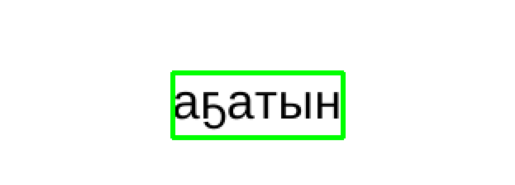

In [29]:
display_image_with_box(annotations[5])

In [30]:
# Создание списков путей к изображениям и текстов
image_paths = []
texts = []

for annotation in annotations:
    img_path = annotation['image']
    text = annotation['text']
    
    if os.path.exists(img_path):
        image_paths.append(img_path)
        texts.append(text)
    else:
        print(f"Изображение не найдено: {img_path}")

In [31]:
train_images, temp_images, train_texts, temp_texts = train_test_split(
    image_paths, texts, test_size=0.2, random_state=42)

val_images, test_images, val_texts, test_texts = train_test_split(
    temp_images, temp_texts, test_size=0.5, random_state=42)

print(f"Train: {len(train_images)}, Validation: {len(val_images)}, Test: {len(test_images)}")

Train: 800, Validation: 100, Test: 100


In [32]:
# Определение набора символов
characters = string.ascii_letters + string.digits + 'абвгдеёжзийклмнопрстуфхцчшщъыьэюяҕҥөһүАБВГДЕЁЖЗИЙКЛМНОПРСТУФХЦЧШЩЪЫЬЭЮЯҔҤӨҺҮ '

# Создание маппинга
char_to_num = {char: idx + 1 for idx, char in enumerate(characters)}  # 0 будет использоваться для CTC blank
num_to_char = {idx + 1: char for idx, char in enumerate(characters)}

def text_to_labels(text):
    return [char_to_num[char] for char in text if char in char_to_num]

def labels_to_text(labels):
    return ''.join([num_to_char[label] for label in labels if label in num_to_char])


In [33]:
def preprocess_image(image_path, img_height, img_width):
    img = cv2.imread(image_path, cv2.IMREAD_COLOR)
    if img is None:
        raise ValueError(f"Не удалось загрузить изображение: {image_path}")
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (img_width, img_height))
    img = img_to_array(img)
    img = img / 255.0  # Нормализация
    return img

In [34]:
# Параметры
IMG_HEIGHT = 64
IMG_WIDTH = 256
BATCH_SIZE = 32
MAX_LABEL_LENGTH = 20  

In [35]:
# Кодирование примера
def encode_sample(image_path, text):
    img = preprocess_image(image_path, IMG_HEIGHT, IMG_WIDTH)
    label = text_to_labels(text)
    return img, label

# Обёртка для TensorFlow
def tf_encode(image_path, text):
    img, label = tf.py_function(func=encode_sample, inp=[image_path, text], Tout=[tf.float32, tf.int32])
    img.set_shape([IMG_HEIGHT, IMG_WIDTH, 3])
    label.set_shape([None])
    return img, label

# Создание TensorFlow Dataset
def prepare_dataset(images, texts):
    dataset = tf.data.Dataset.from_tensor_slices((images, texts))
    dataset = dataset.map(tf_encode, num_parallel_calls=tf.data.AUTOTUNE)
    return dataset

In [36]:
train_dataset = prepare_dataset(train_images, train_texts)
val_dataset = prepare_dataset(val_images, val_texts)
test_dataset = prepare_dataset(test_images, test_texts)

In [37]:
def prepare_batch(batch):
    images, labels = batch
    labels = pad_sequences(labels, maxlen=MAX_LABEL_LENGTH, padding='post', value=0)
    label_length = tf.math.count_nonzero(labels, axis=1)
    input_length = tf.ones(tf.shape(labels)[0]) * (IMG_WIDTH // 4)  # Примерное значение, зависит от модели
    return {
        "input_image": images,
        "labels": labels,
        "input_length": input_length,
        "label_length": label_length
    }, None

In [40]:
train_dataset = train_dataset.batch(BATCH_SIZE).map(prepare_batch).prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.batch(BATCH_SIZE).map(prepare_batch).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).map(prepare_batch).prefetch(tf.data.AUTOTUNE)

TypeError: in user code:


    TypeError: outer_factory.<locals>.inner_factory.<locals>.tf__prepare_batch() takes 1 positional argument but 2 were given


In [31]:
# Загрузка и предобработка изображений
def load_and_preprocess_image(image_path, img_height, img_width):
    image = load_img(image_path, target_size=(img_height, img_width))
    image = img_to_array(image)
    image = preprocess_input(image)  # Специфичная для ResNet предобработка
    return image

In [32]:
img_height, img_width = 224, 224  # Размеры входных данных для ResNet
images = [load_and_preprocess_image(ann['image'], img_height, img_width) for ann in annotations]
images = np.array(images)

In [33]:
# Кодирование меток для CTC Loss
char_list = 'абвгдеёжзийклмнопрстуфхцчшщъыьэюяҕҥөһү ' + '-'  # Добавляем символ CTC blank
num_classes = len(char_list) + 1  # Количество классов + 1 для CTC blank

In [34]:
char_to_labels = {char: idx for idx, char in enumerate(char_list)}
labels = [[char_to_labels[char] for char in ann['text']] for ann in annotations]

# Паддинг меток
max_label_len = max(len(label) for label in labels)
labels_padded = tf.keras.preprocessing.sequence.pad_sequences(labels, maxlen=max_label_len, padding='post', value=num_classes-1)

# Создание массивов input_length и label_length
input_length = np.full((len(images), 1), img_width // 32 * img_height // 32 - 2)  # Оценка длины последовательности после CNN
label_length = np.array([[len(label)] for label in labels])

In [35]:
from tensorflow.keras.layers import Input, Dense, Reshape, Bidirectional, LSTM
from tensorflow.keras.models import Model
from tensorflow.keras.applications import ResNet50

In [39]:
# Построение модели
def build_model():
    input_img = Input(shape=(img_height, img_width, 3), name='image_input')
    base_model = ResNet50(weights='imagenet', include_top=False, input_tensor=input_img)
    for layer in base_model.layers:
        layer.trainable = False  # Замораживаем веса ResNet

    x = base_model.output
    x = Reshape(target_shape=(-1, 2048))(x)
    x = Bidirectional(LSTM(256, return_sequences=True, dropout=0.2))(x)
    output = Dense(num_classes, activation='softmax', name='output')(x)

    labels = Input(name='labels', shape=[max_label_len], dtype='int64')
    input_length = Input(name='input_length', shape=[1], dtype='int64')
    label_length = Input(name='label_length', shape=[1], dtype='int64')

    def ctc_lambda_func(args):
        y_pred, labels, input_length, label_length = args
        return tf.keras.backend.ctc_batch_cost(labels, y_pred, input_length, label_length)

    loss_out = tf.keras.layers.Lambda(ctc_lambda_func, output_shape=(1,), name='ctc')([output, labels, input_length, label_length])

    model = Model(inputs=[input_img, labels, input_length, label_length], outputs=loss_out)
    return model

model = build_model()
model.compile(optimizer='adam', loss={'ctc': lambda y_true, y_pred: y_pred})

In [40]:
# Создание Dataset
train_dataset = tf.data.Dataset.from_tensor_slices(({
    'image_input': images, 
    'labels': labels_padded, 
    'input_length': input_length, 
    'label_length': label_length
    }, np.zeros(len(images)))).batch(16)

In [41]:
history = model.fit(train_dataset, epochs=50)

Epoch 1/50
63/63 [==============================] - 7s 33ms/step - loss: 30.5711
Epoch 2/50
63/63 [==============================] - 2s 32ms/step - loss: 23.2354
Epoch 3/50
63/63 [==============================] - 2s 32ms/step - loss: 22.6501
Epoch 4/50
63/63 [==============================] - 2s 32ms/step - loss: 22.1890
Epoch 5/50
63/63 [==============================] - 2s 32ms/step - loss: 21.7094
Epoch 6/50
63/63 [==============================] - 2s 32ms/step - loss: 21.2569
Epoch 7/50
63/63 [==============================] - 2s 32ms/step - loss: 20.8315
Epoch 8/50
63/63 [==============================] - 2s 33ms/step - loss: 20.3403
Epoch 9/50
63/63 [==============================] - 2s 32ms/step - loss: 19.9711
Epoch 10/50
63/63 [==============================] - 2s 32ms/step - loss: 19.5223
Epoch 11/50
63/63 [==============================] - 2s 33ms/step - loss: 19.0524
Epoch 12/50
63/63 [==============================] - 2s 32ms/step - loss: 18.5467
Epoch 13/50
63/63 [======

In [42]:
def preprocess_image(image_path, img_height, img_width):
    # Загрузка изображения, изменение размера и предварительная обработка
    image = load_img(image_path, target_size=(img_height, img_width))
    image = img_to_array(image)
    image = preprocess_input(image)  # Применяем ту же предобработку, что и для обучения
    image = np.expand_dims(image, axis=0)  # Расширяем размеры для сети
    return image

# Предполагается, что у вас есть путь к изображению
image_path = 'images/а5атын.png'
image = preprocess_image(image_path, img_height, img_width)

In [44]:
# Создание подмодели для предсказания
predict_model = Model(inputs=model.get_layer(name='image_input').input,
                      outputs=model.get_layer(name='output').output)


In [46]:
# Предобработка изображения
def preprocess_image(image_path, img_height, img_width):
    image = load_img(image_path, target_size=(img_height, img_width))
    image = img_to_array(image)
    image = preprocess_input(image)
    image = np.expand_dims(image, axis=0)  # Добавляем batch размерность
    return image

image_path = 'images/а5атын.png'
image = preprocess_image(image_path, img_height, img_width)


In [47]:
preds = predict_model.predict(image)

1/1 [==============================] - 1s 1s/step


In [53]:
char_list = 'абвгдеёжзийклмнопрстуфхцчшщъыьэюяҕҥөһү '

# Функция для декодирования выхода из модели
def decode_predict_ctc(out):
    input_len = np.ones(out.shape[0]) * out.shape[1]
    decoded, _ = tf.keras.backend.ctc_decode(out, input_length=input_len, greedy=True)
    decoded = tf.keras.backend.get_value(decoded[0])

    # Преобразование из индексов в символы, игнорируя CTC blank (0) и -1
    pred_text = ''.join([num_to_char[x] for x in decoded[0] if x != -1 and x != 0])
    return pred_text

# Декодирование предсказаний в текст
predicted_text = decode_predict_ctc(preds)
print("Распознанный текст:", predicted_text)

Распознанный текст: към
